In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import json
sns.set_theme()
from datetime import datetime

In [5]:
if not os.path.exists("figures"):
    os.mkdir("figures")
figure_path = lambda x: os.path.join("figures", x)
with open("config.json") as f:
    config = json.load(f)

## 1. Compare Time

In [6]:
num_event = [10, 20, 40, 80, 160]
num_pick = [500, 1000, 2000, 4000, 8000]
num_sta = 25
time_gamma = [1.10, 3.51, 9.87, 35.14, 149.71]
time_real = [57.48, 94.86, 188.36, 405.86, 769.67]

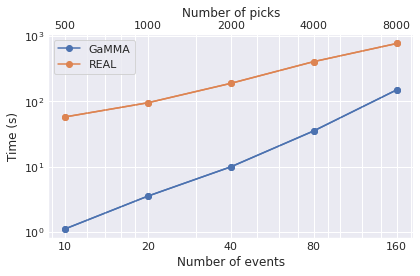

In [7]:
fig, ax = plt.subplots()
ax.plot(num_event, time_gamma, "o-")
ax.plot(num_event, time_real, "o-")
ax.set_xlabel("Number of events")
ax.set_ylabel("Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.grid(True, which='minor')
ax.set_xticks(num_event, num_event)
ax.tick_params(axis='both', which='both', length=0)

twiny = ax.twiny()
twiny.plot(num_pick, time_gamma, "o-", label="GaMMA")
twiny.plot(num_pick, time_real, "o-", label="REAL")
twiny.set_xlabel("Number of picks")
twiny.set_xscale("log")
twiny.set_yscale("log")
twiny.xaxis.grid(True, which='minor')
twiny.set_xticks(num_pick, num_pick)
twiny.tick_params(axis='both', which='both', length=0)

twiny.legend()
fig.tight_layout()

plt.savefig(figure_path("time_comparison.jpg"), dpi=300, bbox_inches="tight")
plt.savefig(figure_path("time_comparison.pdf"), bbox_inches="tight")

## 2. Calculate Precision and Recall

In [82]:
def confusion_matrix(label, pred, threshold=[3.0]):
    index = np.ones([len(pred), len(label)]) * True
    for i in range(len(threshold)):
        diff = label[np.newaxis, :, i] - pred[:, np.newaxis, i]
        index = np.logical_and(index, np.abs(diff) < threshold[i])
    # true_pred = np.sum(np.any(np.abs(diff) < threshold, axis=1))
    # recall_label = np.sum(np.any(np.abs(diff) < threshold, axis=0))
    true_pred = np.sum(np.any(index, axis=1))
    recall_label = np.sum(np.any(index, axis=0))
    precision = true_pred / len(pred)
    print(true_pred, len(pred))
    recall = recall_label / len(label)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"precision: {precision:.2f}, recall: {recall:.2f}, f1: {f1:.2f}")
    return precision, recall, f1

In [86]:
synthetic_events = pd.read_csv("synthetic_events.csv", sep="\t")
synthetic_events["timestamp"] = synthetic_events["time"].apply(lambda x: datetime.fromisoformat(x).timestamp())
print(len(synthetic_events))

50


In [87]:
gamma_catalog = pd.read_csv("catalog_gamma.csv", sep="\t")
gamma_catalog["timestamp"] = gamma_catalog["time"].apply(lambda x: datetime.fromisoformat(x).timestamp())
print(len(gamma_catalog))

50


In [88]:
confusion_matrix(synthetic_events[["timestamp", "x(km)", "y(km)"]].to_numpy(), 
                 gamma_catalog[["timestamp", "x(km)", "y(km)"]].to_numpy(), 
                 threshold=[3.0, 5.0, 5.0])

confusion_matrix(synthetic_events[["timestamp"]].to_numpy(), 
                 gamma_catalog[["timestamp"]].to_numpy(), 
                 threshold=[3.0])

confusion_matrix(synthetic_events[["timestamp", "x(km)", "y(km)"]].to_numpy(), 
                 gamma_catalog[["timestamp", "x(km)", "y(km)"]].to_numpy(), 
                 threshold=[3.0, 15.0, 15.0])



50 50
precision: 1.00, recall: 1.00, f1: 1.00
50 50
precision: 1.00, recall: 1.00, f1: 1.00
50 50
precision: 1.00, recall: 1.00, f1: 1.00


(1.0, 1.0, 1.0)

In [73]:
# real_catalog = pd.read_csv("real/catalog_sel.txt", sep="\s+", header=None, names=["num", "year", "mon", "day", "time_raw", "time_seconds", "residual", "lat", "lon", "dep", "mag", "mag_var", "num_p", "num_s", "num_picks", "num_stations", "station_gap"])
real_catalog = pd.read_csv("real/10_4_4_0/hypolocSA.dat", sep="\s+", header=None, names=["year", "mon", "day", "hh", "mm", "ss", "lat", "lon", "dep", "mag", "num_pick", "sta_gap", "residual", "num"])
real_catalog["x(km)"] = (real_catalog["lon"] - config["center"][0]) * config["degree2km"]
real_catalog["y(km)"] = (real_catalog["lat"] - config["center"][1]) * config["degree2km"]
real_catalog["time"] = real_catalog.apply(lambda x: f"{x.year:04.0f}-{x.mon:02.0f}-{x.day:02.0f}T{x.hh:02.0f}:{x.mm:02.0f}:{x.ss:06.3f}", axis=1)
real_catalog["timestamp"] = real_catalog["time"].apply(lambda x: datetime.fromisoformat(x).timestamp())
print(len(real_catalog))

50


In [74]:
# confusion_matrix(synthetic_events[["timestamp"]].to_numpy(), real_catalog[["timestamp"]].to_numpy(), threshold=[3.0])
confusion_matrix(synthetic_events[["timestamp"]].to_numpy(), real_catalog[["timestamp"]].to_numpy(), threshold=[3.0])

confusion_matrix(synthetic_events[["timestamp", "x(km)", "y(km)"]].to_numpy(), 
                 real_catalog[["timestamp", "x(km)", "y(km)"]].to_numpy(), 
                 threshold=[3.0, 15.0, 15.0])

50 50
precision: 1.00, recall: 1.00, f1: 1.00
46 50
precision: 0.92, recall: 0.92, f1: 0.92


(0.92, 0.92, 0.92)

## 3. Time Error and Amplitude Error

In [14]:
# time_err = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) * 100
# precision_gamma = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# recall_gamma    = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# f1_gamma        = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# sigma11_gamma   = [0.00, 0.11, 0.22, 0.33, 0.44, 0.53]
# sigma22_gamma   = [0.00, 0.00, 0.01, 0.01, 0.01, 0.02]

In [15]:
# amp_err = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) * 100
# precision_gamma = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# recall_gamma    = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# f1_gamma        = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# sigma11_gamma   = [0.00, 0.00, 0.01, 0.01, 0.01, 0.01]
# sigma22_gamma   = [0.00, 0.20, 0.39, 0.52, 0.69, 0.76]

In [16]:
## Time and Amplitude Error together

time_err = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
amp_err = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
err = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
precision_gamma = [1.00, 1.00, 1.00, 1.00, 0.98, 0.93]
recall_gamma    = [1.00, 1.00, 1.00, 1.00, 1.00, 0.96]
f1_gamma        = [1.00, 1.00, 1.00, 1.00, 0.99, 0.94]
sigma11_gamma   = [0.00, 0.19, 0.38, 0.56, 0.74, 0.88]
sigma22_gamma   = [0.00, 0.20, 0.40, 0.60, 0.76, 0.83]

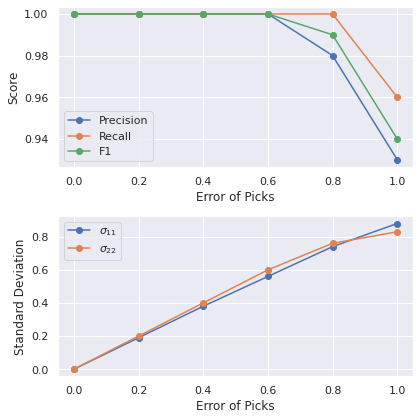

In [17]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(6, 6))
ax[0].plot(amp_err, precision_gamma, "o-", label="Precision")
ax[0].plot(amp_err, recall_gamma, "o-", label="Recall")
ax[0].plot(amp_err, f1_gamma, "o-", label="F1")
ax[0].set_xlabel(r"Error of Picks")
ax[0].set_ylabel("Score")
ax[0].set_xticks(amp_err, amp_err)
ax[0].legend()

ax[1].plot(amp_err, sigma11_gamma, "o-", label=r"$\sigma_{11}$")
ax[1].plot(amp_err, sigma22_gamma, "o-", label=r"$\sigma_{22}$")
ax[1].set_xlabel(r"Error of Picks")
ax[1].set_ylabel("Standard Deviation")
ax[1].set_xticks(amp_err, amp_err)
ax[1].legend()

fig.tight_layout()

plt.savefig(figure_path("pick_error.jpg"), dpi=300, bbox_inches="tight")
plt.savefig(figure_path("pick_error.pdf"), bbox_inches="tight")

## 4. False Positive Rate

In [18]:
## using a time threshold of 3.0, using a space threshold of 5.0, 
# false_positive_rate = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) * 100
# precision_gamma = [1.00, 1.00, 0.96, 1.00, 0.94, 0.96]
# recall_gamma    = [1.00, 1.00, 0.98, 1.00, 0.98, 0.98]
# f1_gamma        = [1.00, 1.00, 0.97, 1.00, 0.96, 0.97]
# sigma11_gamma   = [0.00, 0.05, 0.08, 0.07, 0.11, 0.11]
# sigma22_gamma   = [0.00, 0.05, 0.05, 0.04, 0.07, 0.07]

false_positive_rate = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
false_positive_rate = false_positive_rate / (false_positive_rate + 1) * 100
precision_gamma = [1.00, 1.00, 1.00, 0.98, 0.92, 0.74]
recall_gamma    = [1.00, 1.00, 1.00, 1.00, 0.96, 0.96]
f1_gamma        = [1.00, 1.00, 1.00, 0.99, 0.94, 0.84]
sigma11_gamma   = [0.38, 0.39, 0.40, 0.42, 0.44, 0.50]
sigma22_gamma   = [0.40, 0.38, 0.39, 0.40, 0.40, 0.43]

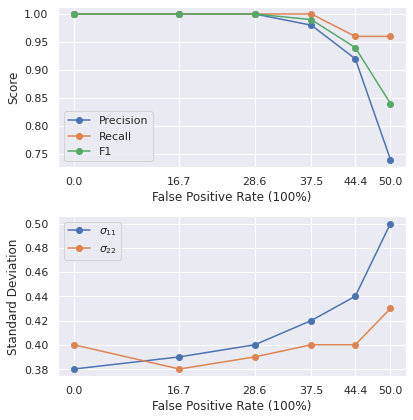

In [19]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(6, 6))
ax[0].plot(false_positive_rate, precision_gamma, "o-", label="Precision")
ax[0].plot(false_positive_rate, recall_gamma, "o-", label="Recall")
ax[0].plot(false_positive_rate, f1_gamma, "o-", label="F1")
ax[0].set_xlabel("False Positive Rate (100%)")
ax[0].set_ylabel("Score")
ax[0].set_xticks(false_positive_rate, [f"{x:.1f}" for x in false_positive_rate])
ax[0].legend()

ax[1].plot(false_positive_rate, sigma11_gamma, "o-", label=r"$\sigma_{11}$")
ax[1].plot(false_positive_rate, sigma22_gamma, "o-", label=r"$\sigma_{22}$")
ax[1].set_xlabel("False Positive Rate (100%)")
ax[1].set_ylabel("Standard Deviation")
ax[1].set_xticks(false_positive_rate, [f"{x:.1f}" for x in false_positive_rate])
ax[1].legend()

fig.tight_layout()

plt.savefig(figure_path("false_positive.jpg"), dpi=300, bbox_inches="tight")
plt.savefig(figure_path("false_positive.pdf"), bbox_inches="tight")

## 5. Velocity Model

In [20]:
## using a threshold of 3.0
# err_vel = np.array([-0.0, -0.1, -0.2, -0.3, -0.4]) * 100
# precision_gamma = [1.00, 1.00, 1.00, 0.79, 0.51]
# recall_gamma    = [1.00, 1.00, 1.00, 0.82, 0.46]
# f1_gamma        = [1.00, 1.00, 1.00, 0.81, 0.48]
# sigma11_gamma   = [0.00, 0.05, 0.12, 0.23, 0.30]
# sigma22_gamma   = [0.00, 0.02, 0.04, 0.05, 0.14]

## using a time threshold of 3.0 s, spatical threshold of 15.0 km
err_vel = np.array([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3]) * 100
# err_vel = (1/(err_vel + 1) - 1) * 100 
precision_gamma = [0.65, 0.92, 1.00, 1.00, 0.96, 0.72]
recall_gamma    = [0.66, 0.94, 1.00, 1.00, 0.96, 0.74]
f1_gamma        = [0.66, 0.93, 1.00, 1.00, 0.96, 0.74]
sigma11_gamma   = [0.69, 0.52, 0.40, 0.50, 0.60, 0.64]
sigma22_gamma   = [0.40, 0.39, 0.39, 0.39, 0.39, 0.39]


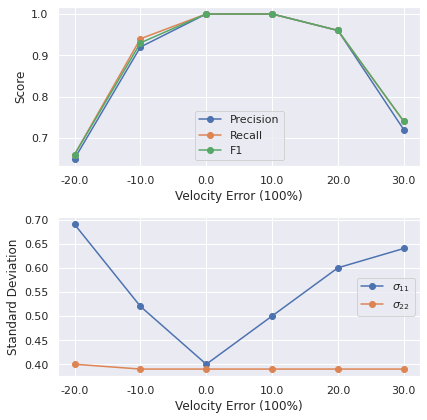

In [21]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(6, 6))
ax[0].plot(err_vel, precision_gamma, "o-", label="Precision")
ax[0].plot(err_vel, recall_gamma, "o-", label="Recall")
ax[0].plot(err_vel, f1_gamma, "o-", label="F1")
ax[0].set_xlabel("Velocity Error (100%)")
ax[0].set_ylabel("Score")
ax[0].set_xticks(err_vel, err_vel)
ax[0].legend()

ax[1].plot(err_vel, sigma11_gamma, "o-", label=r"$\sigma_{11}$")
ax[1].plot(err_vel, sigma22_gamma, "o-", label=r"$\sigma_{22}$")
ax[1].set_xlabel("Velocity Error (100%)")
ax[1].set_ylabel("Standard Deviation")
ax[1].set_xticks(err_vel, err_vel)
ax[1].legend()

fig.tight_layout()
plt.savefig(figure_path("velocity_error.jpg"), dpi=300, bbox_inches="tight")
plt.savefig(figure_path("velocity_error.pdf"), bbox_inches="tight")

## 6. Oversampling Rate

In [22]:
##### vp *= 0.9
##### vs *= 0.9
##### phase_amp_err = 0.4
##### phase_time_err = 0.4
##### phase_fp_rate = 0.4

# sampling_rate = np.array([0.1, 0.5, 1., 2., 3., 4., 5., 8.0])
# # err_vel = (1/(err_vel + 1) - 1) * 100 
# precision_gamma = [0.98, 1.00, 0.92, 0.92, 0.96, 0.94, 0.94]
# recall_gamma    = [0.80, 0.98, 0.94, 0.94, 0.98, 0.96, 0.96]
# f1_gamma        = [0.88, 0.99, 0.93, 0.93, 0.97, 0.95, 0.95]
# sigma11_gamma   = [0.57, 0.53, 0.52, 0.52, 0.52, 0.52, 0.52]
# sigma22_gamma   = [0.43, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39]

sampling_rate = np.array([0.5, 1., 2., 4., 8.0])
# err_vel = (1/(err_vel + 1) - 1) * 100 
precision_gamma = [0.98, 1.00, 0.92, 0.96, 0.94]
recall_gamma    = [0.80, 0.98, 0.94, 0.98, 0.96]
f1_gamma        = [0.88, 0.99, 0.93, 0.97, 0.95]
sigma11_gamma   = [0.57, 0.53, 0.52, 0.52, 0.52]
sigma22_gamma   = [0.43, 0.39, 0.39, 0.39, 0.39]

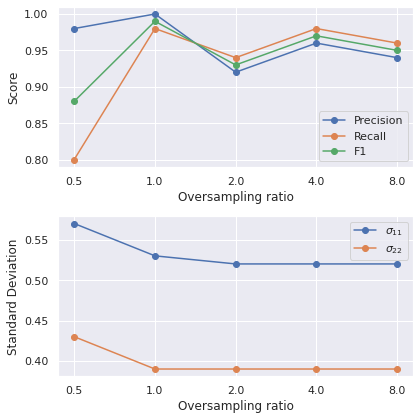

In [23]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(6, 6))
ax[0].plot(sampling_rate, precision_gamma, "o-", label="Precision")
ax[0].plot(sampling_rate, recall_gamma, "o-", label="Recall")
ax[0].plot(sampling_rate, f1_gamma, "o-", label="F1")
ax[0].set_xlabel("Oversampling ratio")
ax[0].set_ylabel("Score")
ax[0].set_xscale("log")
ax[0].set_xticks(sampling_rate, sampling_rate)
ax[0].legend()

ax[1].plot(sampling_rate, sigma11_gamma, "o-", label=r"$\sigma_{11}$")
ax[1].plot(sampling_rate, sigma22_gamma, "o-", label=r"$\sigma_{22}$")
ax[1].set_xlabel("Oversampling ratio")
ax[1].set_ylabel("Standard Deviation")
ax[1].set_xscale("log")
ax[1].set_xticks(sampling_rate, sampling_rate)
ax[1].legend()

fig.tight_layout()

plt.savefig(figure_path("oversampling.jpg"), dpi=300, bbox_inches="tight")
plt.savefig(figure_path("oversampling.pdf"), bbox_inches="tight")

In [24]:
## 
real_4 = [0.94, 0.90, 0.92]